## Importing a Visium dataset

In this tutorial we will run through an example of importing a sample of Visium data. Writing helper functions to import Visium data is tricky, as the structure of the different datasets produced using Visium have varied file structures (in terms of variable files names, different outputs depending on bin/spot size, etc.). As a result, this tutorial will show you what files to look for to import the data using this helper function. Due to this varied file structure, we have not developed a dedicated function as for Xenium, therefore we will require to know a little more about the data organisation of a Visium experiment. (Remember that if you have coordinate data (coordinates of points or shapes) you can always use the standard methods (e.g. `add_points`, `add_shapes`, `add_labels` etc) to import your data in to MuSpAn - this tutorial is just designed to address common requirements when working with Visium data.)

For this example, we will be using a sample of human colon, which can be downloaded from [this link](https://www.10xgenomics.com/datasets/visium-cytassist-gene-expression-libraries-of-post-xenium-human-colon-cancer-ffpe-using-the-human-whole-transcriptome-probe-set-2-standard). In particular, these data are from human colon cancer samples (FFPE; adenocarcinoma stage IIA) obtained from Avaden Biosciences. This dataset can be used to follow along, or otherwise your own dataset can be used.

### What to look for in a Visium dataset to import to MuSpAn

Once we have downloaded our dataset and saved it to a local directory on your machine, open the dataset folder to check what is inside. For this example, our folder is named 'Visium CytAssist Gene Expression Libraries of Post-Xenium Human Colon Cancer (FFPE)'. As with our Xenium tutorial, we recommend using the 10x Visium viewer software [Loupe Browser](https://www.10xgenomics.com/support/software/loupe-browser/latest) alongside MuSpAn to get an interactive understanding of the dataset that is being analysed. 

For now, we will import the spatial and spot clustering data into MuSpAn. For this, we will open our Visum data folder (for me this is `path/to/my/data/Visium CytAssist Gene Expression Libraries of Post-Xenium Human Colon Cancer (FFPE)`) and find the location of the relevent folders we'll need. These folders **end** with the are the following:

| Folder | Description |
|----------|----------|
| _spatial.tar.gz    | Spatial data and information for spot scaling   |
| _analysis.tar.gz  | Spot cluster information   |
| _deconvolution.tar.gz    | Topic cluster values   |

Once we have located all these files, we are ready to import the data. We'll start with our usual imports and some additonal Python standard librarys that will allow use to extract the relevent data from the Visium files.


In [1]:
# Import necessary libraries
import muspan as ms
import numpy as np

# Imports to make our plots look nice
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set plot parameters
mpl.rcParams['figure.dpi'] = 270
sns.set_theme(style='white', font_scale=2)

# Additional imports to extract the data from the relevant files
import json
import tarfile
import pandas as pd

Let's start by defining the path to our data, and the number of topics I'd like to import from the deconvolution data.

In [2]:
# Define the path to the data directory
path_to_the_data = 'path/where/you/saved/the/data/Visium CytAssist Gene Expression Libraries of Post-Xenium Human Colon Cancer (FFPE)'

# Define the number of topics to import from the deconvolution data
number_of_topics = 16

Next we will find the path for the relevent the folders in the table above. 

**Warning!** This is where your datasets may differ in file structure, and the path to each file will have to match the location of where the relevant files are saved with the Visium output file. For this example dataset, it is fairly simple as all folders are located directly in the main data folder. However, depending on the type of experiment they could be tucked away in a deeper folder, so you may have to look for the relevant paths.

In [3]:
# Define the paths to the relevant data files within the dataset directory
spatial_data_file = path_to_the_data + '/' + 'CytAssist_FFPE_Human_Colon_Rep1_spatial.tar.gz'
cluster_data_file = path_to_the_data + '/' + 'CytAssist_FFPE_Human_Colon_Rep1_analysis.tar.gz'
deconv_data_file = path_to_the_data + '/' + 'CytAssist_FFPE_Human_Colon_Rep1_deconvolution.tar.gz'

Now let's import the data. We will use the spot identifier `barcode` to align and link the relevent data.

In [4]:
# Open the spatial data tar file
spatial_tar = tarfile.open(spatial_data_file, "r")
spatial_tar_folder_name = spatial_tar.getnames()[0]

# Extract the scalefactors_json.json file
spatial_meta_name = spatial_tar_folder_name + '/scalefactors_json.json'
spatial_meta = spatial_tar.extractfile(spatial_meta_name)
spatial_meta_dict = spatial_meta.read()
spot_centre_scalefactors = json.loads(spatial_meta_dict)

# Get the scale factor and spot diameter from the scalefactors_json.json file
px_to_dist_scale_factor = spot_centre_scalefactors['regist_target_img_scalef']
spot_diameter = spot_centre_scalefactors['spot_diameter_fullres']

# Get the locations and metadata of the spots
spatial_positions_name = spatial_tar_folder_name + '/tissue_positions.csv'
spatial_positions_file = spatial_tar.extractfile(spatial_positions_name)
spatial_positions = pd.read_csv(spatial_positions_file)

# Open the cluster data tar file
cluster_tar = tarfile.open(cluster_data_file, "r")
cluster_tar_folder_name = cluster_tar.getnames()[0]

# Extract the clustering data
clustering_name = cluster_tar_folder_name + '/clustering/gene_expression_graphclust/clusters.csv'
clustering_file = cluster_tar.extractfile(clustering_name)
clustering_csv = pd.read_csv(clustering_file)
clustering_csv['Cluster'] = pd.to_numeric(clustering_csv['Cluster'])

# Open the deconvolution data tar file
deconv_tar = tarfile.open(deconv_data_file, "r")
deconv_folders = deconv_tar.getnames()
deconv_folders_name = deconv_folders[0]

# Extract the deconvolution data for the specified number of topics
this_deconv_name = deconv_folders_name + '/deconvolution_k' + str(number_of_topics) + '/deconvolved_spots_k' + str(number_of_topics) + '.csv'
if this_deconv_name in deconv_folders:
    deconv_file = deconv_tar.extractfile(this_deconv_name)
    deconv_csv = pd.read_csv(deconv_file)
    
    # Convert the deconvolution data to numeric values
    for col_name in deconv_csv.columns.values.tolist():
        if col_name != 'Barcode':
            deconv_csv[col_name] = pd.to_numeric(deconv_csv[col_name])
else:
    print(f'Error: Number of topics is not stored in Visium experiment data. No deconvolution data has been added to the domain.')

As we only want to analyse the data that is contained within the tissue, let's filter out any spots (and other data) that are not contained within the tissue.

In [5]:
# Create a mask for spots that are in the tissue
spot_mask = np.where(np.array(spatial_positions.in_tissue) > 0)[0]

# Filter spots that are in the tissue and convert their positions to the correct scale
spot_centres = px_to_dist_scale_factor * np.array([spatial_positions.pxl_col_in_fullres, -spatial_positions.pxl_row_in_fullres]).T
spot_centres = spot_centres[spot_mask, :]

# Filter barcodes that are in the tissue
barcode_id = spatial_positions.barcode[spot_mask]

In the next step, we'll match the relevant cluster and deconvolution data to the order of each spot.

In [6]:
# Initialize lists and dictionary to store cluster IDs and deconvolution data
cluster_id = []
deconv = {}

# Setting up the deconvolution dictionary with empty lists for each topic
for col_name in deconv_csv.columns.values.tolist():
    if col_name != 'Barcode':
        deconv[col_name] = []

# For each barcode ID, find the associated cluster and deconvolution data
for b_id in barcode_id:
    # Find the index of the current barcode in the clustering data
    cluster_index = np.where(clustering_csv['Barcode'] == b_id)[0][0]
    # Append the corresponding cluster ID to the cluster_id list
    cluster_id.append(clustering_csv['Cluster'][cluster_index])
    
    # Find the index of the current barcode in the deconvolution data
    deconv_index = np.where(deconv_csv['Barcode'] == b_id)[0][0]
    # Append the corresponding deconvolution data to the deconv dictionary
    for col_name in deconv_csv.columns.values.tolist():
        if col_name != 'Barcode':
            deconv[col_name].append(deconv_csv[col_name][deconv_index])

# Create a list of spot diameters to use as labels
spot_diameter_labels = [spot_diameter] * len(spot_centres)

# Convert barcode_id to a list
barcode_id = barcode_id.tolist()

Now all our data is extracted and organised, we can create an empty MuSpAn domain, and add the Visium data using the standard methods (`add_points` etc).

In [7]:
# Create a MuSpAn domain for the Visium dataset
vis_domain = ms.domain('Visium CytAssist Gene Expression Libraries of Post-Xenium Human Colon Cancer (FFPE)')

# Add the spot positions to the domain as point objects
vis_domain.add_points(spot_centres, 'Spots')

# Add the barcode labels to the domain
vis_domain.add_labels('Barcode', barcode_id, 'Spots')

# Add the spot cluster labels to the domain
vis_domain.add_labels('Spot cluster', cluster_id, 'Spots')

# Add the spot diameter labels to the domain as continuous labels
vis_domain.add_labels('Spot diameter', spot_diameter_labels, 'Spots', label_type='continuous')

# Add the deconvolution data to the domain as continuous labels
for col_name in deconv_csv.columns.values.tolist():
    if col_name != 'Barcode':
        vis_domain.add_labels(col_name, deconv[col_name], 'Spots', label_type='continuous', cmap='viridis')

# Print the domain to ensure everything is as expected
print(vis_domain)

Domain name: Visium CytAssist Gene Expression Libraries of Post-Xenium Human Colon Cancer (FFPE)
Number of objects: 6487
Collections: ['Spots']
Labels: ['Barcode', 'Spot cluster', 'Spot diameter', 'Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6', 'Topic 7', 'Topic 8', 'Topic 9', 'Topic 10', 'Topic 11', 'Topic 12', 'Topic 13', 'Topic 14', 'Topic 15', 'Topic 16'] 
Networks: [] 
Distance matrices: []


We can see we've added our spot barcode IDs, clusters, and diameters to the each point object. Also, each deconvolution topic ID has been added as an independent continuous label. Let's make sure the data looks as we'd expect from using the Loupe Browser software.

(<Figure size 2700x2700 with 2 Axes>, <Axes: >)

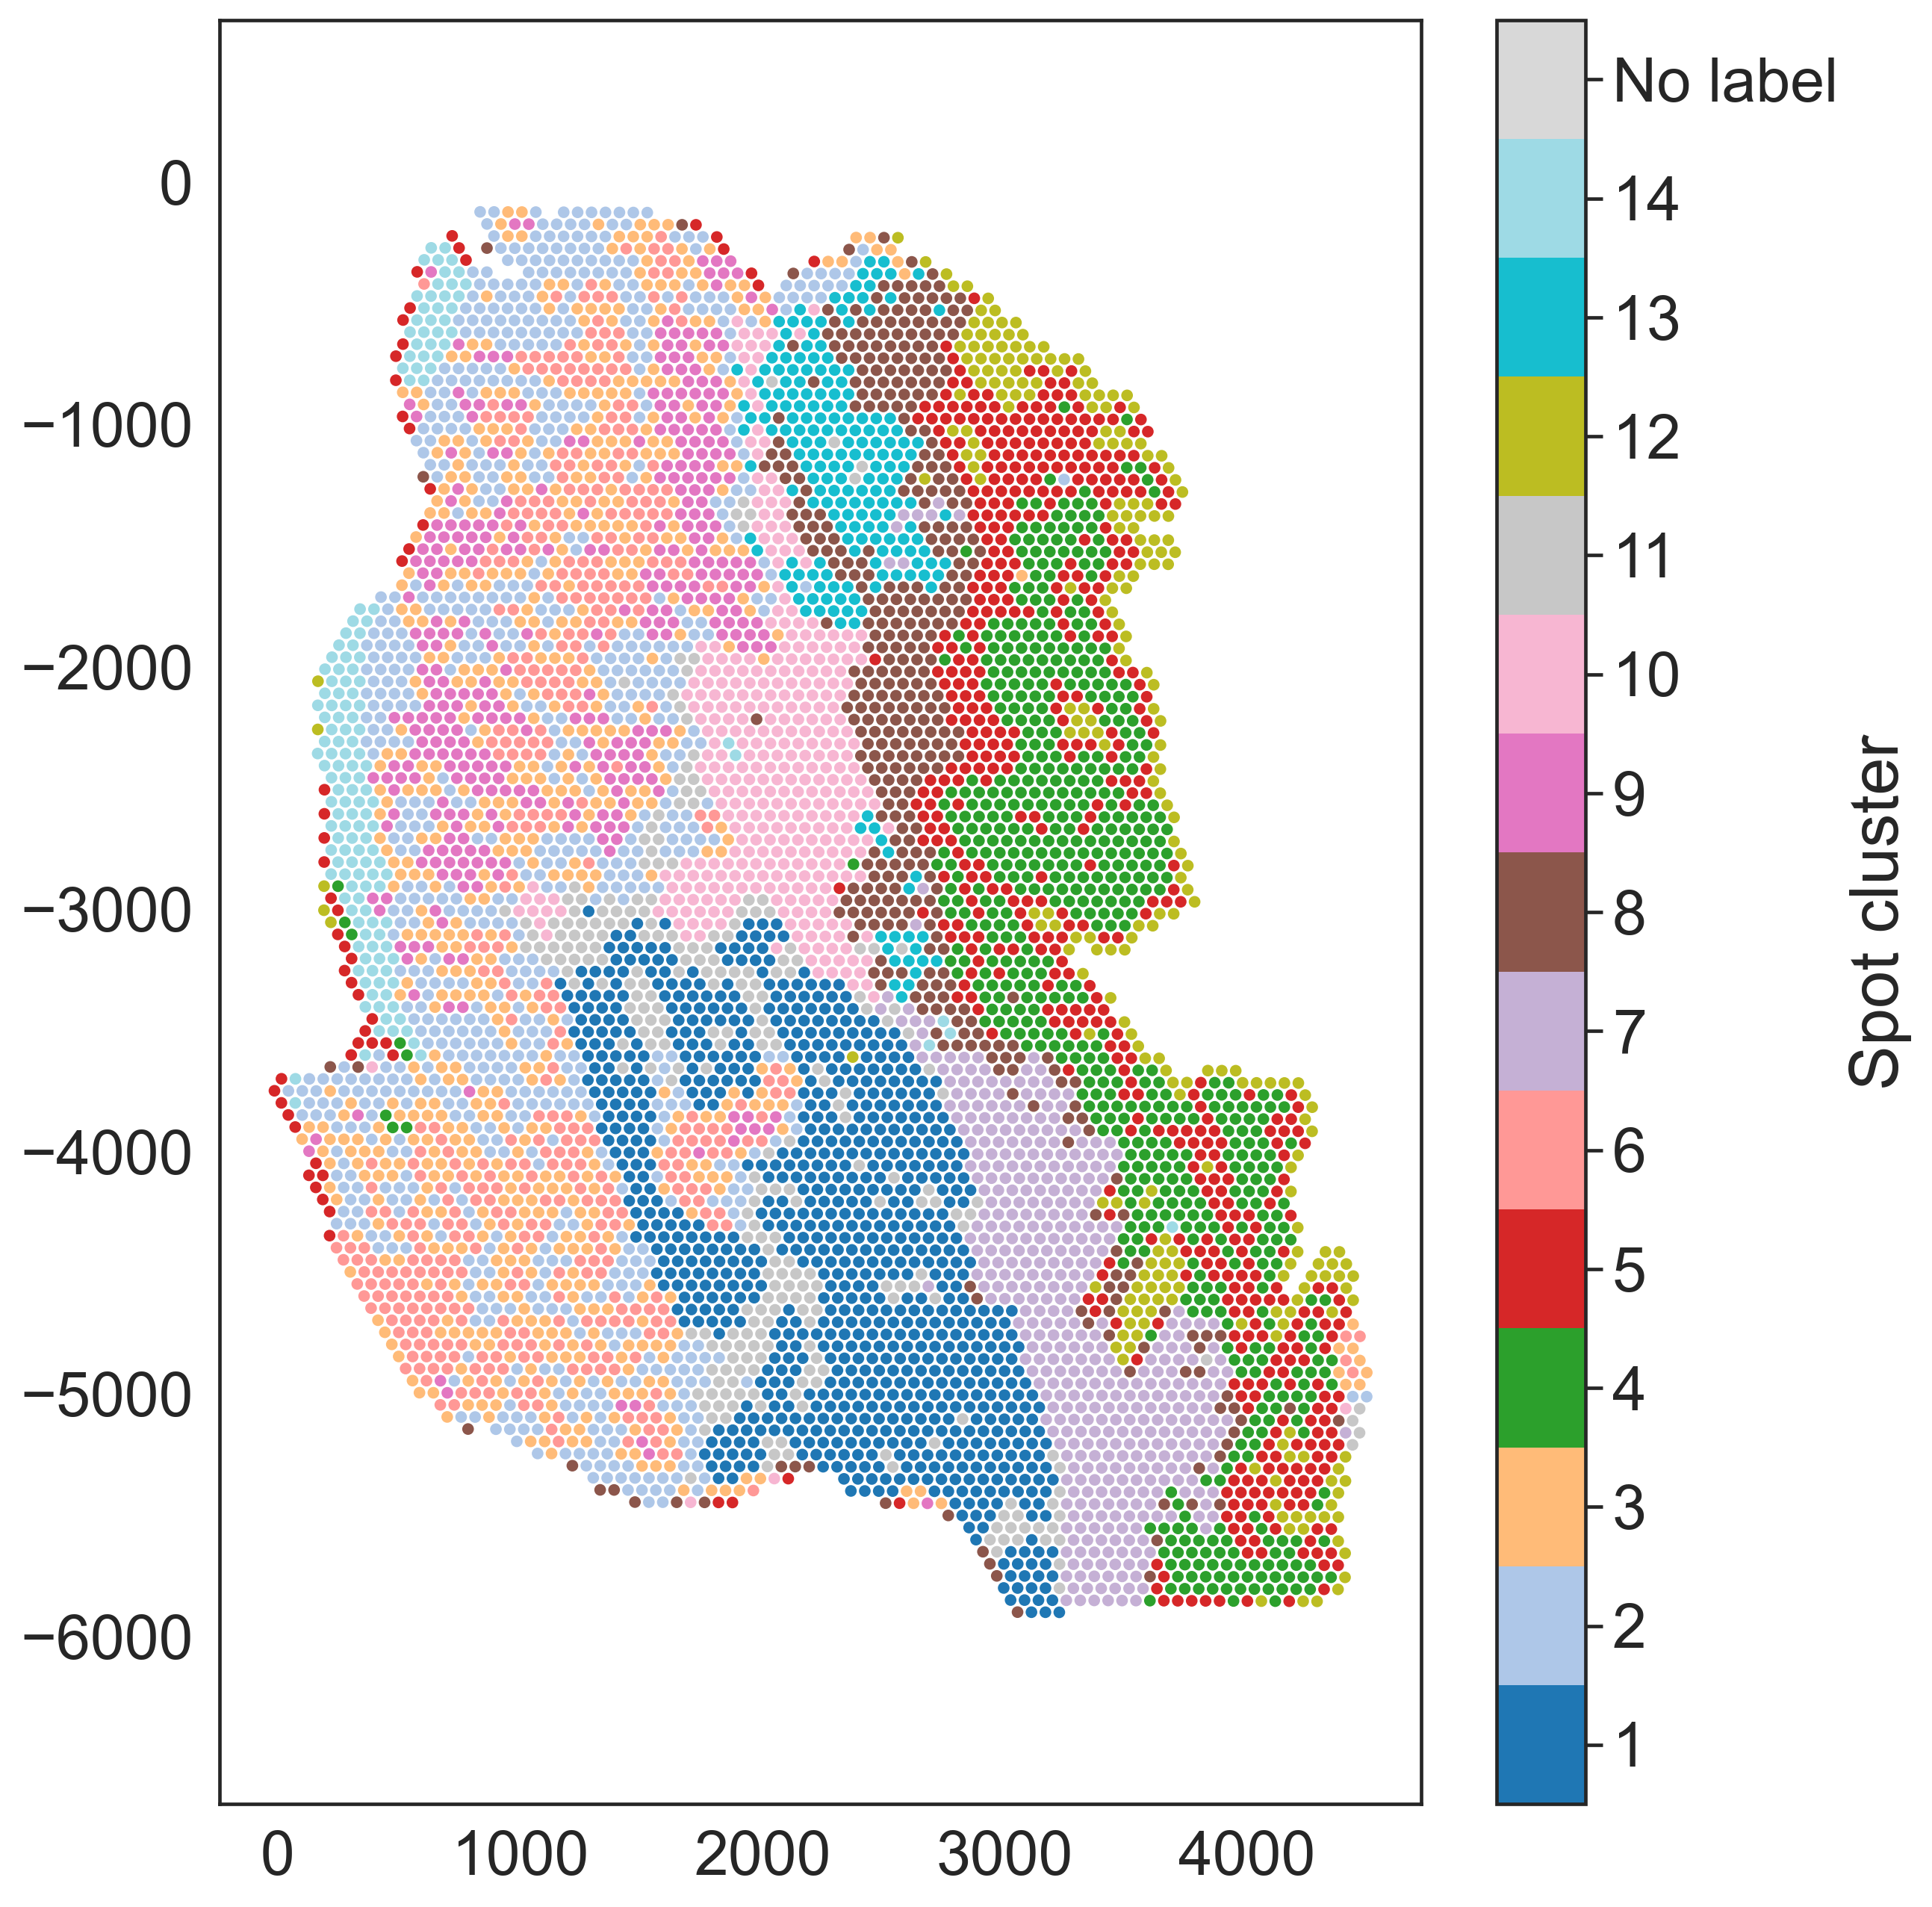

In [8]:
# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(10, 10), nrows=1, ncols=1)

# Visualize the Visium domain, coloring by spot cluster labels
ms.visualise.visualise(
    vis_domain,
    color_by=('label', 'Spot cluster'),
    show_boundary=False,
    marker_size=10,
    vmin=0,
    vmax=0.5,
    ax=ax
)

We should also check that the deconvolution data agrees with what we would expect. Let's plot this to check.

(<Figure size 2700x2700 with 2 Axes>, <Axes: >)

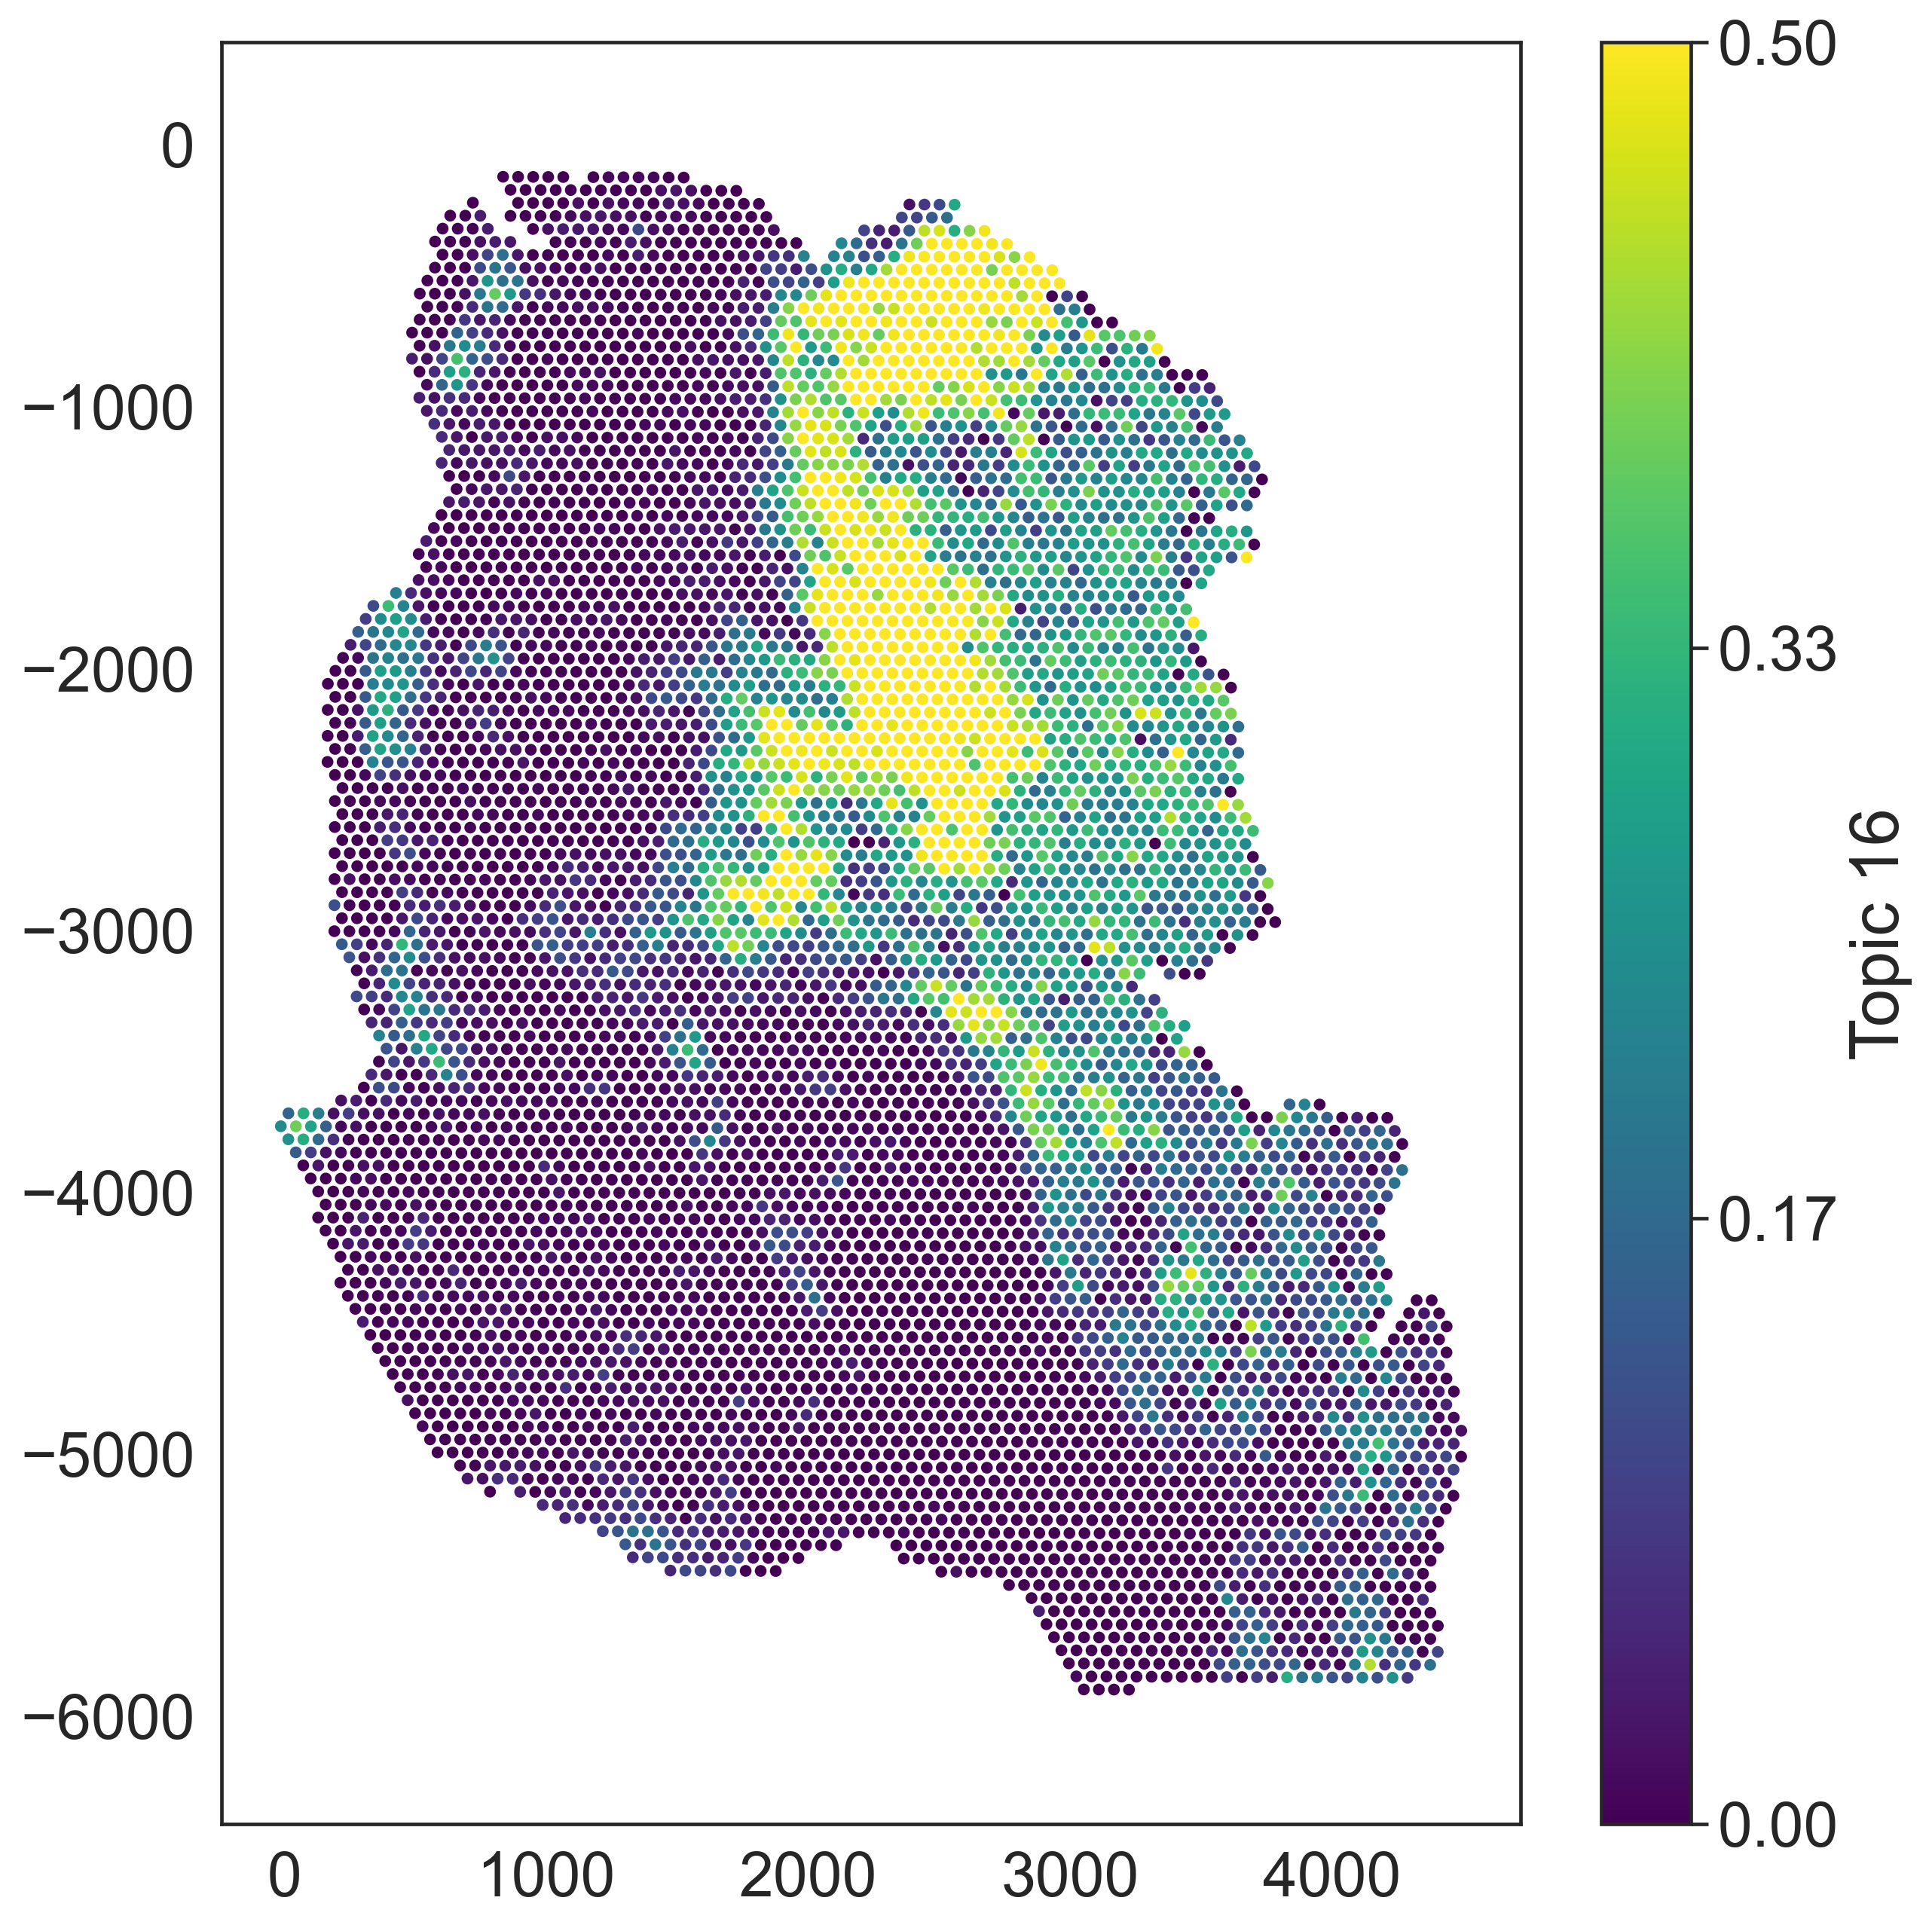

In [9]:
# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(10, 10), nrows=1, ncols=1)

# Visualize the Visium domain, coloring by Topic 16
ms.visualise.visualise(
    vis_domain,
    color_by=('label', 'Topic 16'),
    show_boundary=False,
    marker_size=10,
    vmin=0,
    vmax=0.5,
    ax=ax
)

Great, now we have our spots with their associated data and are ready to conduct some spatial analysis.

### Extra information: network analysis

As the Visium data is naturally embedded with a characteristic spatial length scale (spot diameter), we can easily use this to define networks that define spot neighbourhoods. For example, we can define a Delaunay network where the maximum edge length in the spatial network is matched to the radius of each spot.

In [10]:
# Calculate the radius of each spot from the spot diameter
spot_radius = vis_domain.labels['Spot diameter']['labels'][0] / 2

# Generate a Delaunay-based network for the Visium domain
# The network is distance-weighted with edges limited by the spot radius
G = ms.networks.generate_network(
    vis_domain,
    network_name='Spot network',
    network_type='delaunay',
    distance_weighted=True,
    min_edge_distance=0,
    max_edge_distance=spot_radius
)

This network (which, following the documentation and tutorials on networks, is also stored in our domain `vis_domain`) will allow us to analyse the connectivity of adjacent spots (neighbourhood analysis) and their wider spatial structure. Let's take a look at the resulting network.

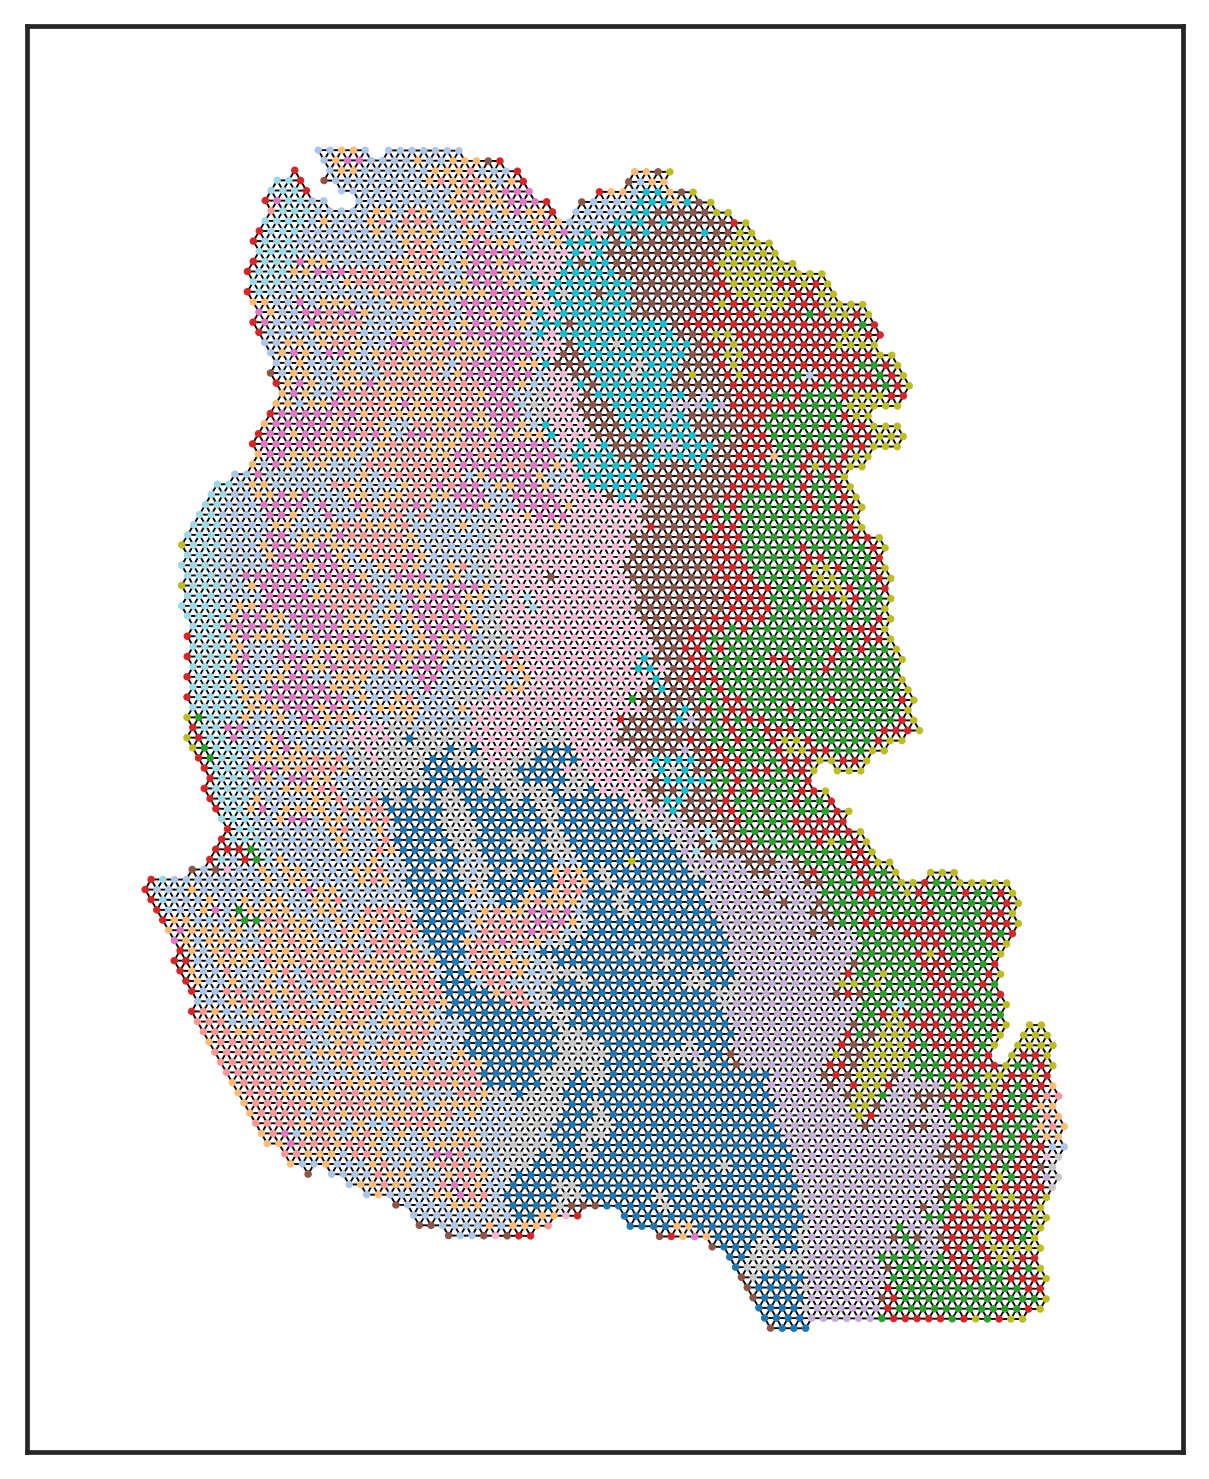

In [11]:
# Create a figure and axis for the plot with specified size
fig, ax = plt.subplots(figsize=(5, 6), nrows=1, ncols=1)

# Visualize the network of spots in the Visium domain
# Color the spots by their cluster labels, without adding a color bar
# Set marker size and edge width for better visualization
ms.visualise.visualise_network(
    vis_domain,
    network_name='Spot network',
    color_by=('label', 'Spot cluster'),
    add_cbar=False,
    ax=ax,
    marker_size=1,
    edge_width=0.5
)